<a href="https://colab.research.google.com/github/HR0262/PCMCI-in-commuter-trian/blob/main/PCMCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tigramite
!pip install dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.3 MB/s eta 0:00:00


In [2]:
# Imports
import numpy as np
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import pandas as pd
import pickle
import networkx as nx

In [3]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI
from tigramite.jpcmciplus import JPCMCIplus

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite.independence_tests.gpdc import GPDC

from tigramite.plotting import plot_time_series_graph
from tigramite.plotting import plot_graph

In [4]:
df = pd.read_csv(r"/content/data_4041_20230502_mp.csv", index_col=0)
#df.drop(columns=['Unnamed: 0'], inplace=True)
df.index.name = None
display(df)

1_Tumba  2_Tullinge  3_Flemingsberg  4_Huddinge  5_Stuvsta  6_Älvsjö  \
0_41     112.0       112.0           116.0       100.0       77.0      43.0   
1_40     -18.0       -20.0             1.0         4.0      -10.0     -41.0   
2_41     -37.0       -42.0           -30.0       -35.0      -56.0    -100.0   
3_41     149.0       152.0           147.0       134.0      128.0      86.0   
4_40      -6.0        -6.0             7.0         3.0      -25.0     -66.0   
5_41     240.0       994.0          1066.0      1074.0     1079.0    1051.0   
6_41     -40.0       -42.0           -23.0       -20.0      -21.0     -50.0   
7_41     -66.0       -67.0           -59.0       -66.0      -90.0    -107.0   
8_40      10.0        25.0            47.0        52.0       55.0      17.0   
9_41       8.0       -58.0           -56.0       -68.0      -86.0    -111.0   
10_41    -83.0       -66.0           -60.0       -69.0      -88.0     -98.0   
11_41    599.0       637.0           646.0       685.0      683.0     657.0   
12_40    348.0       337.0           378.0       411.0      394.0     399.0   
13_41    108.0        78.0           142.0       198.0      185.0     146.0   
14_41    -45.0       -38.0           -13.0       -23.0      -41.0     -64.0   
15_41     21.0        35.0            59.0        50.0       46.0       1.0   
16_40    -71.0       -67.0           -60.0       -70.0      -84.0    -101.0   
17_41     19.0       -54.0           -57.0       -55.0      -76.0    -112.0   
18_41     53.0        56.0            70.0        60.0       43.0     -12.0   
19_41     98.0        79.0            76.0        75.0       48.0     -30.0   
20_40    -22.0       -28.0           -16.0       -26.0      -45.0     -54.0   
21_41    -41.0       -45.0           -37.0       -48.0      -52.0     -66.0   

       7_Årstaberg  8_Stockholms södra  9_Stockholm City  \
0_41          45.0                47.0              54.0   
1_40         -23.0                 7.0              18.0   
2_41         -37.0               -24.0               8.0   
3_41          87.0                93.0             108.0   
4_40          16.0                42.0              73.0   
5_41        1168.0              1415.0            1457.0   
6_41         -23.0                -5.0              28.0   
7_41         -64.0               -67.0             277.0   
8_40          39.0               181.0             347.0   
9_41         -57.0                38.0             187.0   
10_41        -61.0               -56.0             -40.0   
11_41        702.0               887.0             960.0   
12_40        673.0               718.0             757.0   
13_41        399.0               456.0             673.0   
14_41         59.0               108.0             412.0   
15_41         19.0                33.0             279.0   
16_40        -60.0               -58.0              59.0   
17_41        -60.0               -56.0              87.0   
18_41        -16.0                 0.0              22.0   
19_41         -5.0                 7.0              30.0   
20_40        -54.0               -64.0             -39.0   
21_41        -57.0               -54.0             -44.0   

       10_Stockholm Odenplan  11_Solna  12_Ulriksdal  13_Helenelund  \
0_41                     7.0     -29.0         -66.0          -33.0   
1_40                   -26.0     -29.0         -53.0          -29.0   
2_41                   -12.0     -38.0         -78.0          -24.0   
3_41                    63.0      33.0          -4.0            3.0   
4_40                   119.0      71.0          45.0           68.0   
5_41                  1632.0    1607.0        1608.0         1572.0   
6_41                    49.0      37.0          23.0           77.0   
7_41                   233.0     209.0         169.0          171.0   
8_40                   414.0     433.0         418.0          457.0   
9_41                   331.0     317.0         282.0          281.0   
10_41                   16.

In [7]:
df_delay = df.drop(columns=["Departure_Time"])

# PCMCI 用车站作为列，车次作为行 分析

分析车站之间的因果关系

In [8]:
dataframe = pp.DataFrame(data = df_delay.values, var_names = df_delay.columns)

In [9]:
parcorr = ParCorr(significance='analytic')
robust_parcorr=RobustParCorr(significance='analytic')
gpdc = GPDC()

# 早高峰
# 筛选前后
cond_ind_test=gpdc #非线性关系
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=cond_ind_test,
    verbosity=1)
tau_max = 5 #评价影响几个车次，1-10个数多少
pc_alpha = 0.05
pcmci.verbosity = 1

# results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)
results = pcmci.run_pcmci(tau_min=0, tau_max=tau_max, pc_alpha=None,alpha_level=0.05)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = gp_dc
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1




/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarni


## Resulting lagged parent (super)sets:

    Variable 1_Tumba has 4 link(s):
    [pc_alpha = 0.5]
        (3_Flemingsberg -2): max_pval = 0.17200, |min_val| =  0.538
        (12_Ulriksdal -5): max_pval = 0.24800, |min_val| =  0.503
        (1_Tumba -3): max_pval = 0.38200, |min_val| =  0.460
        (3_Flemingsberg -3): max_pval = 0.48800, |min_val| =  0.438

    Variable 2_Tullinge has 3 link(s):
    [pc_alpha = 0.4]
        (14_Sollentuna -5): max_pval = 0.19600, |min_val| =  0.522
        (12_Ulriksdal -5): max_pval = 0.33600, |min_val| =  0.473
        (1_Tumba -3): max_pval = 0.34400, |min_val| =  0.470

    Variable 3_Flemingsberg has 4 link(s):
    [pc_alpha = 0.4]
        (14_Sollentuna -5): max_pval = 0.15400, |min_val| =  0.544
        (7_Årstaberg -2): max_pval = 0.20200, |min_val| =  0.520
        (12_Ulriksdal -5): max_pval = 0.30000, |min_val| =  0.484
        (11_Solna -5): max_pval = 0.36400, |min_val| =  0.464

    Variable 4_Huddinge has 4 link(s):
    [pc_alpha = 0.

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:


## Significant links at alpha = 0.05:

    Variable 1_Tumba has 10 link(s):
        (2_Tullinge  0): pval = 0.00000 | val =  0.846 | unoriented link
        (13_Helenelund -5): pval = 0.01200 | val =  0.796
        (5_Stuvsta  0): pval = 0.01200 | val =  0.795 | unoriented link
        (8_Stockholms södra  0): pval = 0.01200 | val =  0.785 | unoriented link
        (4_Huddinge  0): pval = 0.01200 | val =  0.778 | unoriented link
        (3_Flemingsberg  0): pval = 0.01400 | val =  0.749 | unoriented link
        (7_Årstaberg -4): pval = 0.03400 | val =  0.700
        (8_Stockholms södra -5): pval = 0.03400 | val =  0.697
        (3_Flemingsberg -2): pval = 0.04200 | val =  0.690
        (9_Stockholm City  0): pval = 0.04200 | val =  0.687 | unoriented link

    Variable 2_Tullinge has 18 link(s):
        (3_Flemingsberg  0): pval = 0.00000 | val =  0.947 | unoriented link
        (6_Älvsjö  0): pval = 0.00000 | val =  0.946 | unoriented link
        (5_Stuvsta  0): pval = 0.00000 | va

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


p_matrix[i, j, tau]	vs val_matrix[i, j, tau]

统计检验的 p 值（显著性），条件独立性检验的 统计量（强度），❌ 越小越显著，< 0.05 常用于筛选， 用来判断是否显著、有因果边

val_matrix[i, j, tau]，条件独立性检验的 统计量（强度），✅ 越大（或绝对值大）说明依赖更强，用来排序因果边强弱

用法p < 0.05 筛选显著因果边。用 p_matrix 做初步筛选，再用 val_matrix 判断因果强度。

# p_matrix 筛选 并计数不同tau下连接数



In [11]:
print(results.keys())

p_matrix=results['p_matrix']
print('p_matrix:')
print(p_matrix.shape)
array_1d_p_matrix = p_matrix.reshape(-1)
print(array_1d_p_matrix.shape)
print(len(array_1d_p_matrix[array_1d_p_matrix<0.05]))
graph=results['graph']
print('graph:')
print(graph.shape)
array_1d_graph = graph.reshape(-1)
print(array_1d_graph.shape)
print(len(array_1d_graph[array_1d_graph!='']))

dict_keys(['graph', 'p_matrix', 'val_matrix', 'conf_matrix'])
p_matrix:
(18, 18, 6)
(1944,)
272
graph:
(18, 18, 6)
(1944,)
276


对p_matrix进行筛选

后续站点不会对当前站点造成影响，当前站点的后续车次不会对当前造成影响

p_matrix[i,j,tau]<alpha_level 表示i站点在tau步前对j站点有因果影响

count数不同tau下的因果链接数量

In [37]:
p_matrix_clean = results['p_matrix'].copy()  # 不直接修改原始数据，避免污染

# 遍历所有 target, source, tau 组合
num_vars = p_matrix_clean.shape[0]
tau_max_plus1 = p_matrix_clean.shape[2]
print(p_matrix_clean.shape)
count=[0]*(tau_max+1)

for i in range(num_vars):       # target
    for j in range(num_vars):   # source
        for tau in range(tau_max_plus1):
            target_idx = j+1
            source_idx = i+1

            # 如果后续站点影响当前站点，则置为空字符串
            if source_idx > target_idx:
              p_matrix_clean[i, j, tau] = 1
            elif p_matrix_clean[i, j, tau]<=alpha_level:
              count[tau]+=1


array_1d_p_matrix_clean = p_matrix_clean.reshape(-1)
print(array_1d_p_matrix_clean.shape)
print(len(array_1d_p_matrix_clean[array_1d_p_matrix_clean<=0.05]))
print(count)

(18, 18, 6)
(1944,)
154
[94, 21, 5, 6, 20, 8]


# 可视化部分

边上的数字是前n个站点的延误对当前站点的因果影响

节点颜色的深浅代表auto-MCI values，表明了过去车次对站点的因果影响

边的颜色深浅代表cross-MCI values，表明了其他站点对该站点的因果影响

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

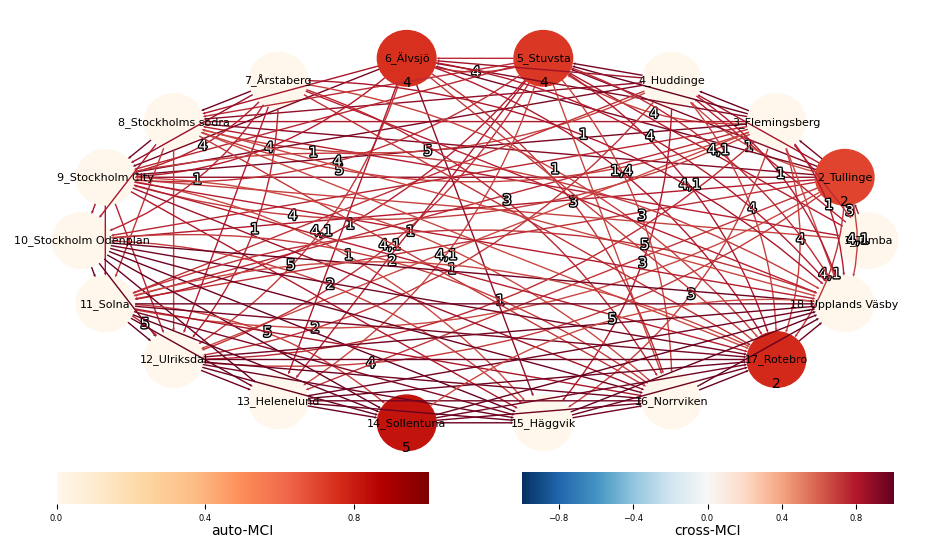

In [27]:
# 需要跟前面节点进行筛选配合，筛选p_matrix，val_matrix

# 设置显著性水平
alpha_level = 0.05

# 从 p_matrix 生成布尔型因果图
graph = pcmci.get_graph_from_pmatrix(
    p_matrix=p_matrix_clean,
    alpha_level=alpha_level,
    tau_min=0,
    tau_max=tau_max
)
# 绘图
plot_graph(
    graph=graph,
    val_matrix=results['val_matrix'],             # 测试统计值，通常是偏相关或其他统计量
    var_names=dataframe.var_names,                # 变量名称（你自己的时间序列名称）
    link_colorbar_label='cross-MCI',                # 显示边的颜色表示的含义（例如：偏相关系数）
    figsize=(12, 6),                              # 图像大小
    alpha=1.0,                                    # 图形的透明度
    arrow_linewidth=1.0,                          # 箭头的线宽
    node_size=0.3,                                # 节点大小
    curved_radius=0.2,                            # 边的弯曲度
    label_fontsize=10,                            # 标签字体大小
    node_label_size=8,                           # 节点标签字体大小
    cmap_edges='RdBu_r',                          # 边的颜色映射（红蓝渐变）
    cmap_nodes='OrRd',                            # 节点的颜色映射
    show_colorbar=True,                           # 显示颜色条
    show_autodependency_lags=True,                # 显示自依赖延迟
    vmin_edges=-1,                                # 边的颜色条范围
    vmax_edges=1.0,                               # 边的颜色条范围
    vmin_nodes=0,                                 # 节点颜色条范围
    vmax_nodes=1.0                                # 节点颜色条范围
)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

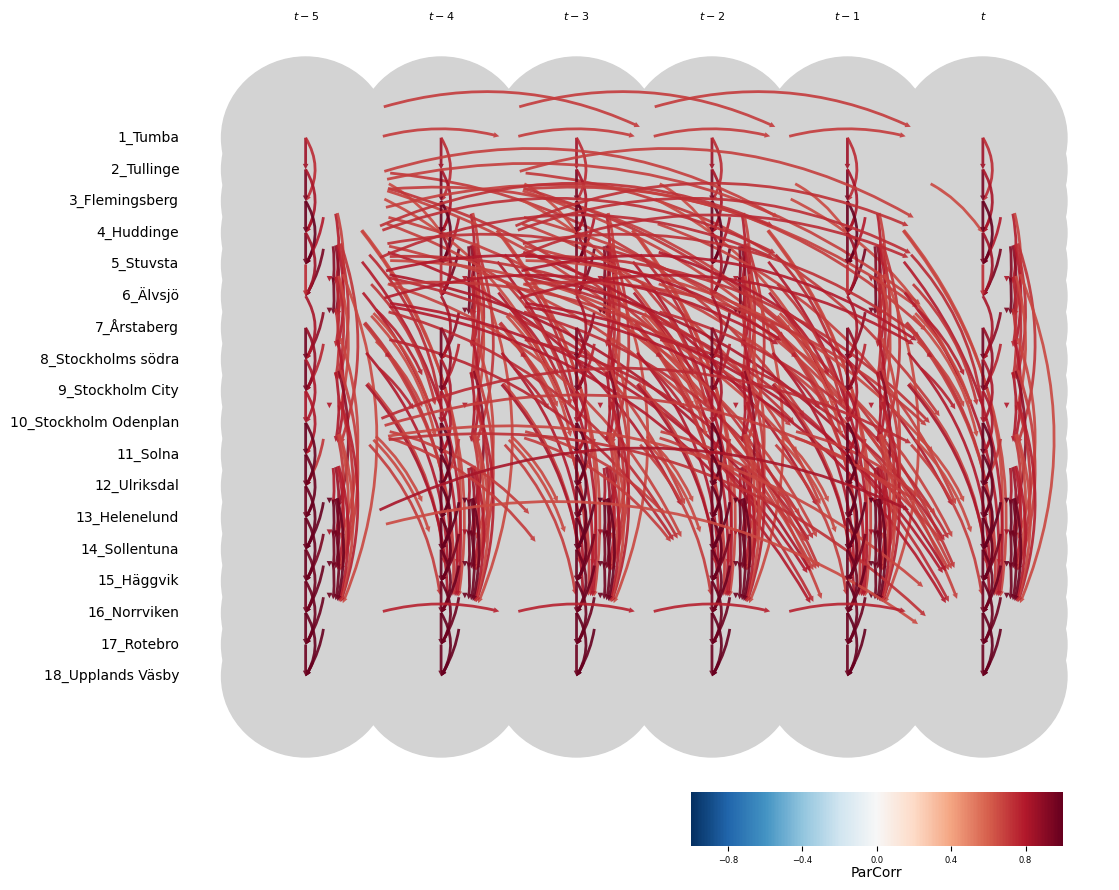

In [34]:
# 设置显著性水平
alpha_level = 0.05

# 从 p_matrix 生成布尔型因果图
graph = pcmci.get_graph_from_pmatrix(
    p_matrix=p_matrix_clean,
    alpha_level=alpha_level,
    tau_min=0,
    tau_max=tau_max
)

# 绘图
plot_time_series_graph(
    graph=graph,
    val_matrix=results['val_matrix'],             # 偏相关值/测试统计值
    var_names=dataframe.var_names,                # 节点名字
    link_colorbar_label='ParCorr',                # 显示偏相关值的图例
    figsize=(12, 10),                              # 图像大小
    alpha=0.9,                                    # 边透明度
    arrow_linewidth=2.0,                          # 箭头线宽
    node_size=0.3,                                # 节点大小
    curved_radius=0.3                             # 边曲率
)

# 数多少tau

定义函数

## 函数

In [47]:
def counttau(tau_input,dataframe):
  gpdc = GPDC()

  # 早高峰
  # 筛选前后
  cond_ind_test=gpdc #非线性关系
  pcmci = PCMCI(
      dataframe=dataframe,
      cond_ind_test=cond_ind_test,
      verbosity=0)
  tau_max = tau_input #评价影响几个车次，1-10个数多少
  pc_alpha = 0.05
  pcmci.verbosity = 0

  # results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)
  results = pcmci.run_pcmci(tau_min=0, tau_max=tau_max, pc_alpha=None,alpha_level=0.05)


  p_matrix_clean = results['p_matrix'].copy()  # 不直接修改原始数据，避免污染

  # 遍历所有 target, source, tau 组合
  num_vars = p_matrix_clean.shape[0]
  tau_max_plus1 = p_matrix_clean.shape[2]
  print(p_matrix_clean.shape)
  count=[0]*(tau_max+1)

  for i in range(num_vars):       # target
      for j in range(num_vars):   # source
          for tau in range(tau_max_plus1):
              target_idx = j+1
              source_idx = i+1

              # 如果后续站点影响当前站点，则置为空字符串
              if source_idx > target_idx:
                p_matrix_clean[i, j, tau] = 1
              elif p_matrix_clean[i, j, tau]<=alpha_level:
                count[tau]+=1

  # array_1d_p_matrix_clean = p_matrix_clean.reshape(-1)
  # print(array_1d_p_matrix_clean.shape)
  # print(len(array_1d_p_matrix_clean[array_1d_p_matrix_clean<=0.05]))
  # print(count)
  return count

## 折叠

In [50]:
count1=counttau(1,dataframe)
count2=counttau(2,dataframe)
count3=counttau(3,dataframe)
count4=counttau(4,dataframe)
count5=counttau(5,dataframe)
count6=counttau(6,dataframe)
count7=counttau(7,dataframe)
count8=counttau(8,dataframe)
# count9=counttau(9,dataframe)
# count10=counttau(10,dataframe)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: Converg

(18, 18, 2)


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarnin

(18, 18, 3)


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarni

(18, 18, 4)


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

(18, 18, 5)


流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.

(18, 18, 6)


流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.

(18, 18, 7)


流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.

(18, 18, 8)


流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels

(18, 18, 9)


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


## 输出结果

In [51]:
print(count1)
print(count2)
print(count3)
print(count4)
print(count5)
print(count6)
print(count7)
print(count8)

[120, 5]
[121, 4, 0]
[97, 11, 6, 7]
[92, 8, 29, 1, 1]
[94, 21, 5, 6, 20, 8]
[50, 68, 8, 4, 2, 3, 70]
[44, 22, 26, 18, 6, 11, 28, 9]
[31, 15, 14, 22, 14, 19, 10, 26, 14]


NameError: name 'count9' is not defined

## 折叠

In [53]:
count9=counttau(9,dataframe)
count10=counttau(10,dataframe)

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning:

KeyboardInterrupt: 

## 输出结果 9 10

In [ ]:
print(count9)
print(count10)